# Introducción
Se trata de un código Python para ajustar espectros Mossbauer obtenidos en espectrómetros de fuentes con movimientos de aceleración constante. (Ver: https://en.m.wikipedia.org/wiki/M%C3%B6ssbauer_spectroscopy). \
# Descripción
En la primer celda se importan las librerías necesarias de *Numpy, Scipy, Pandas, Pathlib, y Matplotlib*. Además, se instala *Lmfit* con el que se hará la regresión lineal.
Si bien no se requiere que esta notebook esté en el mismo directorio Drive donde se encuentra el archivo de datos, se recomienda, ya que cada modelo de ajuste requiere una notebook específica. La variable *img* es la ruta de acceso (path) del directorio y se debe adecuar a la ubicación del archivo de datos

In [2]:
"""
V6 incluye doblado con FFT y suavizado con Savizky-Golay (recomendable solo p/calibraciones de baja estadística) y un ajuste lineal con lmfit.
Además, se incluye la opción de identificación de fases en una Base de Datos mediante un algoritmo de ML basado en K-Nearest Neighbors (KNN)
Preparando para Colab e importando librerías necesarias.
"""
!pip install lmfit
from google.colab import drive
drive.mount('/content/drive/', force_remount= True)
img = '/content/drive/MyDrive/Colab-Notebooks/PyMossFit/INTECIN/M8/M8 calNiNa 15Abr2025'

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from lmfit import Parameters, minimize, fit_report, Model
from scipy.optimize import curve_fit
from scipy.constants import *
from scipy.integrate import trapezoid
from scipy.signal import savgol_filter
from scipy.stats import norm
from pathlib import Path

path= Path(img); file= path.stem; title= path.parent.name; full= path.parents[0]; print(file, title, full)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.2/100.2 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 3.8 MB/s eta 0:00:00
Mounted at /content/drive/
M8 calNiNa 15Abr2025 M8 /content/drive/MyDrive/Colab-Notebooks/PyMossFit/INTECIN/M8


El plegado se hace empleando la librería 'fft' de *Numpy* (Transformada de Fourier Discreta) que permite determinar el mínimo o máximo local en la zona central del espectro de Fourier, que corresponde al canal de doblado, según se define a partir del teorema de Nyquist-Shannon (https://pythonnumericalmethods.studentorg.berkeley.edu/notebooks/chapter24.02-Discrete-Fourier-Transform.html). \

Para determinar el canal de plegado se debe seleccionar *idmax* o *idmin* según corresponda y ajustar el entorno alrededor del canal de plegado. \

Hay una línea opcional, comentada con el símbolo #, que sirve para suavizar espectros con mucho ruido estadístico mediante el algoritmo Savitzky-Golay. Se lo recomienda solo para calibraciones ya que suelen medirse durante menos tiempo.
En esta sección se genera el archivo $calib.txt$ que guardará la información de la fecha de calibración, la $V_{max}$ que define los mm/s por canal y el número de canales del espectrómetro. Además, el archivo $.csv$ que tendrá dos columnas: $V(mm/s)$ y el espectro doblado y normalizado.

Ingrese la fecha de calibración (AAAAMMDD): 20250415
Ingrese el rango de V (en mm/s): -8.4


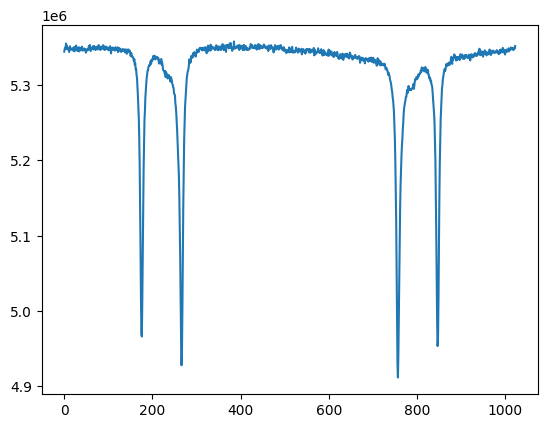

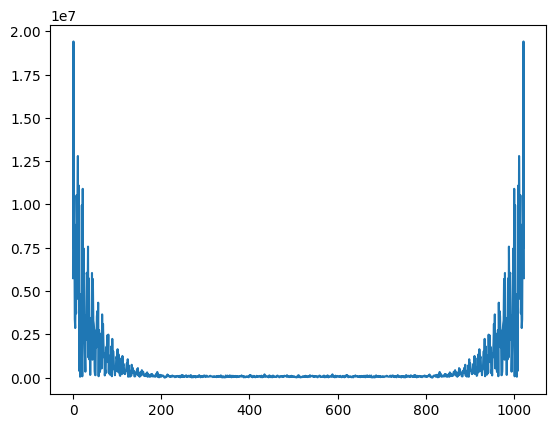

Media del fondo: 10694592
Canal de doblado: 513


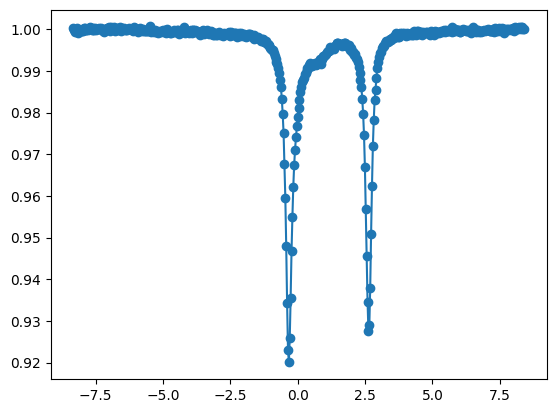

In [3]:
"""
Para doblar, normalizar y calibrar en mm/s, los archivos del espectrómetro de CNEA de 512 canales
"""
y= np.loadtxt(img, skiprows=0); #y=y[:,1] #agregar delivery=" " o delimiter=" " en loadtxt si es de dos columnas. Caso contrario comentar y=y[:,1]
N=len(y); N2=int(N/2); N4=int(N/4)

fecha = str(input('Ingrese la fecha de calibración (AAAAMMDD): '),)
vel = float(input('Ingrese el rango de V (en mm/s): ' ), )
np.savetxt(f"{full}/{file}-calib.txt", (fecha,vel, N), fmt='%s')

#y= savgol_filter(y, 5, 2) #solo si se trata de espectro con baja estadística, comentar en otro caso
plt.plot(y)
plt.show()

"""
Doblado con FFT (basado en el Nyquist-Shannon sampling theorem, https://pythonnumericalmethods.studentorg.berkeley.edu/notebooks/chapter24.02-Discrete-Fourier-Transform.html)
"""
f= abs(np.fft.fft(y)); Nf=pd.Series(f[N2-5:N2+5]).idxmax()+(N2-5)
plt.plot(f[1:N])
plt.show()

for i in range(0, Nf-1):
    y[[i]]=y[[i]]+y[[N-1-i]]

y=y[0:N2-1]

"""
Normalización
"""
y2= np.concatenate([y[2:30],y[N2-30:N2-2]])

ymax=np.mean(y2)
ymax=int(ymax)

for i in range(0, N2-1):
    y[[i]]=y[[i]]/ymax

x=np.arange(1,N2)

"""
de canales a escala de velocidades en mm/s
"""
v=np.loadtxt(f"{full}/{file}-calib.txt"); vmax=v[[1]]

x=np.linspace(start = 0, stop = N2-1, num= N2)

for i in range(0, N2-1):
    x[[i]]=(i-N4)*vmax/N4

x= x[0:N2-1]

print('Media del fondo:', ymax); print('Canal de doblado:', Nf)

plt.plot(x,y, marker="o")
plt.show()

np.savetxt(f"{full}/{file}.csv", list(zip(x,y)), delimiter=",", fmt='%1.6f')

La siguiente celda realiza el ajuste del espectro ya doblado y normalizado en la celda anterior y reporta los parámetros obtenidos. Las funciones de ajuste definidas son Singletes (*singlet, S*), Dobletes (*doublet, Q*) y Sextetes (*sextet, X*) para entornos cristalinos del núcleo sonda y distribuciones para entornos desordenados. Estos últimos son histograma de sextetes (*dist*). Estas funciones se restan al background en Transmisión y se suman en medidas CEMS. \
Cada modelo exige un número de interacciones hiperfinas agregadas en el *y_fit* y se recomienda agregar los parámetros ordenados cardinalmente en cada sección. \
La determinación de las áreas de cada subespectro se realiza con la función *trapz* de *Scipy*. \
Hay dos archivos de salida *plot* (a varias columnas con $V(mm/s)$, datos normalizados, subespectros y el total del modelo) y *report* (que tiene los parámetros hiperfinos finales del ajuste para cada interacción propuesta). El porcentaje relativo de cada subespectro $z_{i}$ se incluye en el archivo de salida *report*.

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 198
    # data points      = 511
    # variables        = 8
    chi-square         = 2.2309e-04
    reduced chi-square = 4.4352e-07
    Akaike info crit   = -7467.24252
    Bayesian info crit = -7433.35157
[[Variables]]
    d1_delta:  1.15203257 +/- 4.9813e-04 (0.04%) (init = 1.1)
    d1_quad:   2.96251317 +/- 9.9026e-04 (0.03%) (init = 2.9)
    d1_gamma:  0.12869219 +/- 7.1741e-04 (0.56%) (init = 0.35)
    d1_scale:  0.01475312 +/- 7.0190e-05 (0.48%) (init = 0.2)
    d2_delta:  0.31396036 +/- 0.00926377 (2.95%) (init = 0.4)
    d2_quad:   0.81234902 +/- 0.01444463 (1.78%) (init = 0.4)
    d2_gamma:  0.35000000 +/- 0.01181261 (3.38%) (init = 0.35)
    d2_scale:  0.00433089 +/- 8.6060e-05 (1.99%) (init = 0.2)
[[Correlations]] (unreported correlations are < 0.100)
    C(d1_gamma, d1_scale) = +0.7035
    C(d2_gamma, d2_scale) = +0.6157
    C(d1_scale, d2_scale) = -0.5747
    C(d1_scale, d2_delta) = +0.3600


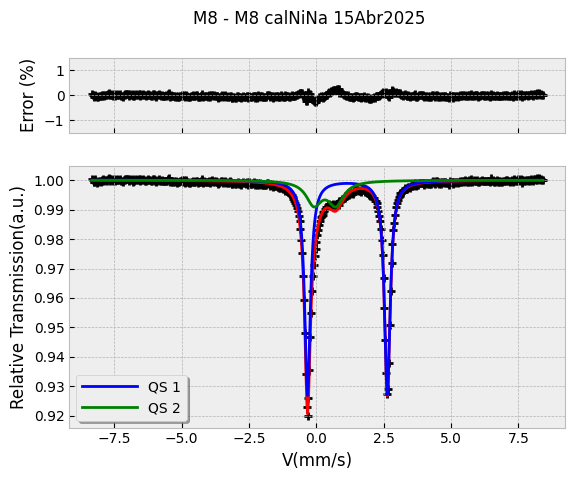

In [4]:
"""
LECTURA DE ARCHIVO DE ENTRADA
"""
col_list=[0, 1]

x, y= np.loadtxt(f"{full}/{file}.csv", delimiter=",", usecols=col_list, unpack=True)

"""
DEFINICIÓN DE LAS FUNCIONES Y DISTRIBUCIONES BASADAS EN LORENTZIANAS
"""
# Constantes Mössbauer para el doblete (factores de transición entre niveles)
positions_d = np.array([-1 , 1]) / 2  # Relativas a B_hf
intensities_d = np.array([1, 1])  # Relativa intensidad de cada línea

# Constantes Mössbauer para el sexteto (factores de transición entre niveles)
positions_x = np.array([-3., -1.7, -0.5, 0.5, 1.7, 3.]) / 2  # Relativas a B_hf
intensities_x = np.array([1, 2, 1., 1., 2, 1])  # Relativa intensidad de cada línea

def lorentzian(x, amplitude, center, width):
    """Función Lorentziana simple"""
    return amplitude * (2*width / ((np.pi) * ((x - center)**2 + width**2)))

def doublet_lorentzian(x, delta, quad, gamma, scale):
    """
    Modelo de doblete de líneas Lorentzianas para un espectro Mössbauer de interacción cuadrupolar.

    Parámetros:
    - delta: desplazamiento isomérico
    - quad: doblete cuadrupolar
    - gamma: ancho de línea de cada componente Lorentziana
    - scale: factor de escala de intensidad
    """
    y = np.zeros_like(x)
    for i, (pos, inten) in enumerate(zip(positions_d, intensities_d)):
        center = delta + pos * quad
        y += lorentzian(x, scale * inten, center, gamma)
    return y

def sextet_lorentzian(x, delta, B_hf, gamma, scale):
    """
    Modelo de sexteto de líneas Lorentzianas para un espectro Mössbauer con un campo magnético.

    Parámetros:
    - delta: desplazamiento isomérico
    - B_hf: campo hiperfino magnético
    - gamma: ancho de línea de cada componente Lorentziana
    - scale: factor de escala de intensidad
    """
    y = np.zeros_like(x)
    for i, (pos, inten) in enumerate(zip(positions_x, intensities_x)):
        center = delta + pos * B_hf
        y += lorentzian(x, scale * inten, center, gamma)
    return y

# Usar lmfit para definir el modelo y realizar el ajuste
from lmfit import Model, minimize, fit_report
doublet1 = Model(doublet_lorentzian, prefix= 'd1_')
doublet2 = Model(doublet_lorentzian, prefix= 'd2_')
combined_model= doublet1 + doublet2

# Configurar parámetros iniciales y límites
params = combined_model.make_params(d1_delta=1.1, d1_quad=2.9, d1_gamma=0.35, d1_scale=0.2, d2_delta=0.4, d2_quad=0.4, d2_gamma=0.35, d2_scale=0.2)
params['d1_delta'].set(min=-0.7, max=1.5)       # Ejemplo de límite para delta
params['d1_quad'].set(min=0, max=3.5)        # Límite para desdoblamiento cuadrupolar
params['d1_gamma'].set(min=0.0, max=0.45)      # Límite para ancho de línea
params['d1_scale'].set(min=0.0, max=1)      # Límite para escala de intensidad

params['d2_delta'].set(min=-0.7, max=1.5)       # Ejemplo de límite para delta
params['d2_quad'].set(min=0, max=0.95)        # Límite para desdoblamiento cuadrupolar
params['d2_gamma'].set(min=0.0, max=0.35)      # Límite para ancho de línea
params['d2_scale'].set(min=0.0, max=1)      # Límite para escala de intensidad

def linear_fitting_lmfit(params, x, y):
    y_fit= 1-combined_model.eval(params=params, x=x)

    return y_fit-y

# Extraer resultados y guardarlos en un DataFrame
param_headers = []
param_values = []
param_errors = []

# Ajuste usando el método de mínimos cuadrados
result = minimize(linear_fitting_lmfit, params, args=(x,y), method='least_squares')
best_fit= 1-combined_model.eval(params=result.params, x=x)

doublet1_fit= doublet1.eval(params=result.params, x=x)
doublet2_fit= doublet2.eval(params=result.params, x=x)

for name, param in result.params.items():
      param_headers.append(name)
      param_values.append(param.value)
      param_errors.append(param.stderr)

#Las áreas de subespectros se calculan como: i= trapz(1-z, x); i1= trapz(1-z1, x)/i*100; i2=trapz(1-z2, x)/i*100; etc con z=z1+z2+...
i = trapezoid(doublet1_fit + doublet2_fit, x)
i1 = trapezoid(doublet1_fit, x)/i*100
i2 = trapezoid(doublet2_fit, x)/i*100

e= (y-best_fit)/y*100

# Imprimir resultados del ajuste
print(fit_report(result))

"""
GRAFICA DE ESPECTROS Y SUBESPECTROS
"""
plt.style.use('bmh')

fig, (ax1, ax2) = plt.subplots(2, sharex=True, height_ratios=[1,3.5]); fig.suptitle(f"{title}" " - " f"{file}")
ax1.scatter (x, e, c= 'black', marker= '+')
ax1.set_ylim(-1.5,1.5)
ax1.set_ylabel('Error (%)'); #plt.axis('tight')

ax2.scatter (x, y, c= 'black', marker= '+')
ax2.set_xlabel('V(mm/s)')
ax2.set_ylabel('Relative Transmission(a.u.)')
ax2.plot(x, best_fit, c='red')
ax2.plot(x, 1-doublet1_fit, c='blue', label= 'QS 1')
ax2.plot(x, 1-doublet2_fit, c='green', label= 'QS 2')
ax2.legend(handlelength=4, loc='lower left', shadow=True)

plt.show()

"""
GENERACIÓN DE ARCHIVOS DE SALIDA: DATOS Y PARÁMETROS
"""
np.savetxt(f"{full}/{file}-plot.csv", list(zip(x, y, doublet1_fit, doublet2_fit, best_fit)), delimiter=',', fmt='%1.6e') #

# Crear un DataFrame con los resultados
results_df = pd.DataFrame({
    'Parameter': param_headers,
    'Value': param_values,
    'Error': param_errors
})

df = pd.DataFrame({
    'Ancho(mm/s)': results_df.loc[results_df['Parameter'].isin(['d1_gamma', 'd2_gamma']), 'Value'].values.tolist(),
    'IS (mm/s)': results_df.loc[results_df['Parameter'].isin(['d1_delta', 'd2_delta']), 'Value'].values.tolist(),
    'Quad Splitting (mm/s)': results_df.loc[results_df['Parameter'].isin(['d1_quad', 'd2_quad']), 'Value'].values.tolist(),
    'Bhf (T)': [0, 0], 'Áreas (%)': [i1, i2] # Ensure 'Bhf (T)' has the same length as others
})

#df= df.apply(lambda x: round (x,1))
df.to_csv(f"{full}/{file}-report.csv", index=False)

La siguiente sección del código permite identificar las fases presentes en la muestra, a partir de los resultados del ajuste, comparando los parámetros de los subespectros con una base de datos en formato CSV. Se cuenta con una base de datos de unos +50 compuestos de Fe con sus datos de espectros Mossbauer de $^{57}Fe$. (Se puede saltear si se conocen las fases presentes)

In [5]:
from sklearn.neighbors import NearestNeighbors

# 1. Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 2. Cargar datos de referencia (base de datos)
reference_path = '/content/drive/MyDrive/Colab-Notebooks/PyMossFit/reference_data.csv'  # ¡Ajusta la ruta!
df_ref = pd.read_csv(reference_path)

# Función para convertir rangos a valores medios (ej: "0.37-0.45" → 0.41)
def parse_value(value):
    if isinstance(value, str) and '-' in value:
        min_val, max_val = map(float, value.split('-'))
        return (min_val + max_val) / 2
    return float(value)

# Procesar columnas relevantes
cols = ['IS (mm/s)', 'Quad Splitting (mm/s)', 'Bhf (T)']
for col in cols:
    df_ref[col] = df_ref[col].apply(parse_value)

# 3. Cargar datos experimentales
experimental_path = f"{full}/{file}-report.csv"  # ¡Ajusta la ruta!
df_exp = pd.read_csv(experimental_path)

# 4. Preprocesar datos experimentales (manejar NaN)
X_exp = df_exp[cols].fillna(0).values  # Si Bhf no existe, reemplazar NaN por 0

# 5. Entrenar modelo KNN
X_ref = df_ref[cols].values
model = NearestNeighbors(n_neighbors=3, metric='euclidean')
model.fit(X_ref)

# 6. Encontrar coincidencias
distances, indices = model.kneighbors(X_exp)

# 7. Mostrar resultados
for i, (dist, idx) in enumerate(zip(distances, indices)):
    print(f"\nMuestra experimental {i+1}:")
    for j, (d, pos) in enumerate(zip(dist, idx)):
        compound = df_ref.iloc[pos]['Compound Name']
        formula = df_ref.iloc[pos]['Chemical Formula']
        is_ref = df_ref.iloc[pos]['IS (mm/s)']
        qs_ref = df_ref.iloc[pos]['Quad Splitting (mm/s)']
        bhf_ref = df_ref.iloc[pos]['Bhf (T)']
        print(f"  Match {j+1}: {compound} ({formula})")
        print(f"    IS: {is_ref:.2f} mm/s | QS: {qs_ref:.2f} mm/s | Bhf: {bhf_ref:.1f} T")
        print(f"    Distancia euclidiana: {d:.2f}\n")

print("## Usar este resultado a modo orientativo. Se recomienda contar con información de la muestra en su composición y estructura ##")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Muestra experimental 1:
  Match 1: Condritas-Olivina ((Mg;Fe)₂SiO₄)
    IS: 1.19 mm/s | QS: 3.00 mm/s | Bhf: 0.0 T
    Distancia euclidiana: 0.06

  Match 2: Fe₂SiO₄ (Fe₂SiO₄)
    IS: 1.15 mm/s | QS: 2.90 mm/s | Bhf: 0.0 T
    Distancia euclidiana: 0.06

  Match 3: LiFePO₄ (Olivine) (LiFePO₄)
    IS: 1.15 mm/s | QS: 2.90 mm/s | Bhf: 0.0 T
    Distancia euclidiana: 0.06


Muestra experimental 2:
  Match 1: (Fe; Mn)PO₄ ((Fe; Mn)PO₄)
    IS: 0.40 mm/s | QS: 0.70 mm/s | Bhf: 0.0 T
    Distancia euclidiana: 0.14

  Match 2: Ferritina (FeOOH core)
    IS: 0.40 mm/s | QS: 0.70 mm/s | Bhf: 0.0 T
    Distancia euclidiana: 0.14

  Match 3: FeVO₄ (FeVO₄)
    IS: 0.45 mm/s | QS: 0.70 mm/s | Bhf: 0.0 T
    Distancia euclidiana: 0.18

## Usar este resultado a modo orientativo. Se recomienda contar con información de la muestra en su composición y estructura ##
